In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
data = pd.read_csv('train.csv')

In [88]:
data.shape

(1460, 63)

# Constant Features

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.drop(['SalePrice'], axis=1), 
                                                    data.SalePrice, test_size=0.3, 
                                                    random_state=0)

In [50]:
numerical_x_train = x_train[x_train.select_dtypes([np.number]).columns]

In [51]:
from sklearn.feature_selection import VarianceThreshold
vs_constant = VarianceThreshold(threshold=0)

In [52]:
vs_constant.fit(numerical_x_train)

VarianceThreshold(threshold=0)

In [42]:
len(x_train[x_train.select_dtypes([np.number]).columns].columns[constant_filter.get_support()])

35

In [53]:
constant_columns = [column for column in numerical_x_train.columns
                    if column not in numerical_x_train.columns[constant_filter.get_support()]]

In [54]:
len(constant_columns)

0

In [78]:
constant_cat_columns = [column for column in x_train.columns 
                        if (x_train[column].dtype == "O" and len(x_train[column].unique())  == 1 )]

In [79]:
all_constant_columns = constant_cat_columns + constant_columns

In [56]:
x_train.drop(labels=constant_columns, axis=1, inplace=True)
x_test.drop(labels=constant_columns, axis=1, inplace=True)

# Quasi Constant features

In [84]:
def constant_feature_detect(data,threshold=0.98):
    
    quasi_constant_feature = []
    for feature in data.columns:
        predominant = (data[feature].value_counts() / np.float(len(data))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)   
    return quasi_constant_feature

In [85]:
x_train.drop(labels=constant_feature_detect(x_train), axis=1, inplace=True)
x_test.drop(labels=constant_feature_detect(x_train), axis=1, inplace=True)

# Duplicated Features
In this

In [34]:
train_features_T = x_train.T
train_features_T.head()

,64,682,960,1384,1100,416,1034,853,472,1011,...,1094,599,277,1033,1383,763,835,1216,559,684
Id,65,683,961,1385,1101,417,1035,854,473,1012,...,1095,600,278,1034,1384,764,836,1217,560,685
MSSubClass,60,120,20,50,30,60,30,80,180,90,...,20,160,20,20,30,60,20,90,120,60
MSZoning,RL,RL,RL,RL,RL,RL,RL,RL,RM,RL,...,RL,RM,RL,RL,RL,RL,RL,RM,RL,RL
LotFrontage,70.05,70.05,50,60,60,74,50,70.05,35,75,...,74,24,140,70.05,70.05,82,60,68,70.05,58
LotArea,9375,2887,7207,9060,8400,7844,6305,12095,3675,9825,...,5868,1950,19138,8125,25339,9430,9600,8930,3196,16770


In [68]:
print(train_features_T.duplicated().sum())

0


In [67]:
train_features_T[train_features_T.duplicated()].index.values

array([], dtype=object)

In [ ]:
x_train.drop(labels=duplicated_columns, axis=1, inplace=True)
x_test.drop(labels=duplicated_columns, axis=1, inplace=True)

In [91]:
corr_feature_detect(data)

[     feature1    feature2      corr
 0  GarageCars  GarageArea  0.882475,        feature1   feature2      corr
 2  TotRmsAbvGrd  GrLivArea  0.825489,       feature1  feature2     corr
 4  TotalBsmtSF  1stFlrSF  0.81953]

# Correlation methods

In [89]:
correlated_features = set()
correlation_matrix = x_train.corr()

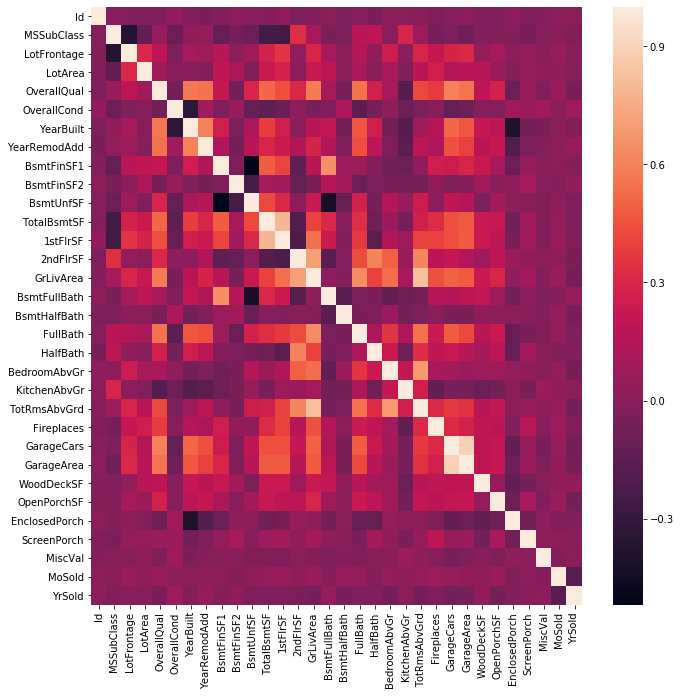

In [97]:
plt.figure(figsize=(11,11))
sns.heatmap(correlation_matrix)

In [93]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [95]:
correlated_features

{'GarageArea', 'TotRmsAbvGrd'}

In [98]:
x_train.drop(labels=correlated_features, axis=1, inplace=True)
x_test.drop(labels=correlated_features, axis=1, inplace=True)

# Statistical Measures

In [99]:
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

### Mutual Information

In [ ]:
def mutual_info(X,y,select_k=10):
    
#    mi = mutual_info_classif(X,y)
#    mi = pd.Series(mi)
#    mi.index = X.columns
#    mi.sort_values(ascending=False)
    
    if select_k >= 1:
        sel_ = SelectKBest(mutual_info_classif, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
        
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(mutual_info_classif, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
        
    else:
        raise ValueError("select_k must be a positive number")
    
    return col
    

### Chi Scire

In [ ]:
def chi_square_test(X,y,select_k=10):
   
    """
    Compute chi-squared stats between each non-negative feature and class.
    This score should be used to evaluate categorical variables in a classification task
    """
    if select_k >= 1:
        sel_ = SelectKBest(chi2, k=select_k).fit(X,y)
        col = X.columns[sel_.get_support()]
    elif 0 < select_k < 1:
        sel_ = SelectPercentile(chi2, percentile=select_k*100).fit(X,y)
        col = X.columns[sel_.get_support()]   
    else:
        raise ValueError("select_k must be a positive number")  
    
    return col

### Univariate ROC-AUC

In [103]:
mse_values = []
for feature in x_train.columns:
    clf = DecisionTreeRegressor()
    clf.fit(x_train[feature].to_frame(), y_train)
    y_scored = clf.predict(x_test[feature].to_frame())
    mse_values.append(mean_squared_error(y_test, y_scored))
mse_values = pd.Series(mse_values)
mse_values.index = x_train.columns
print(mse_values.sort_values(ascending=False))
print(len(mse_values[mse_values > threshold]),'out of the %s featues are kept'% len(x_train.columns))
keep_col = mse_values[mse_values > threshold]
return keep_col   

ValueError: could not convert string to float: 'RL'

In [102]:
roc_values = []
for feature in x_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(x_train[feature].to_frame(), y_train)
    y_scored = clf.predict_proba(x_test[feature].to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
print(roc_values.sort_values(ascending=False))
print(len(roc_values[roc_values > threshold]),'out of the %s featues are kept'% len(X_train.columns))
keep_col = roc_values[roc_values > threshold]
return keep_col

ValueError: multiclass format is not supported